# Demo of RNN

## Data Preparation

### Generate Numpy Sequential Data
- The `gen_wave` function generates 1:sine, 2:square and 3:sawtooth waves.
- `X` is an (`N`, `SEQ_LEN`) array, each row is a sequential wave.
- `y` is an (`N`,) array with values correspond to the class of the row in `X`.

In [1]:
import numpy as np

SEQ_LEN = 100
N_SAMPLES = 6000
N_CLASSES = 3

def gen_wave(wave_type: int, cycles: int, phase: float, seq_len: int):
    """Return a 1D NumPy array of length seq_len for the chosen wave."""
    t = np.linspace(0, 1, seq_len, dtype=np.float32)
    f = float(cycles)  # cycles per second across [0,1]
    if wave_type == 0:      # sine
        x = np.sin(2 * np.pi * f * t + phase)
    elif wave_type == 1:    # square
        x = np.sign(np.sin(2 * np.pi * f * t + phase))
    else:                   # sawtooth in [-1, 1]
        # classic sawtooth: fractional part of f*t mapped to [-1, 1]
        frac = (f * t + phase / (2*np.pi)) % 1.0
        x = 2.0 * (frac - 0.5)
    return x.astype(np.float32)


X_list, y_list = [], []
for _ in range(N_SAMPLES):
    wave_type = np.random.randint(0, 3)                  # 0/1/2
    cycles = np.random.randint(5, 11)                    # 5–10 periods
    phase = np.random.uniform(0.0, 2*np.pi)              # random phase
    wave = gen_wave(wave_type, cycles, phase, SEQ_LEN)
    X_list.append(wave)
    y_list.append(wave_type)

X = np.stack(X_list, axis=0).astype(np.float32)          # (N, SEQ_LEN)
y = np.array(y_list, dtype=np.int64)                     # (N,)

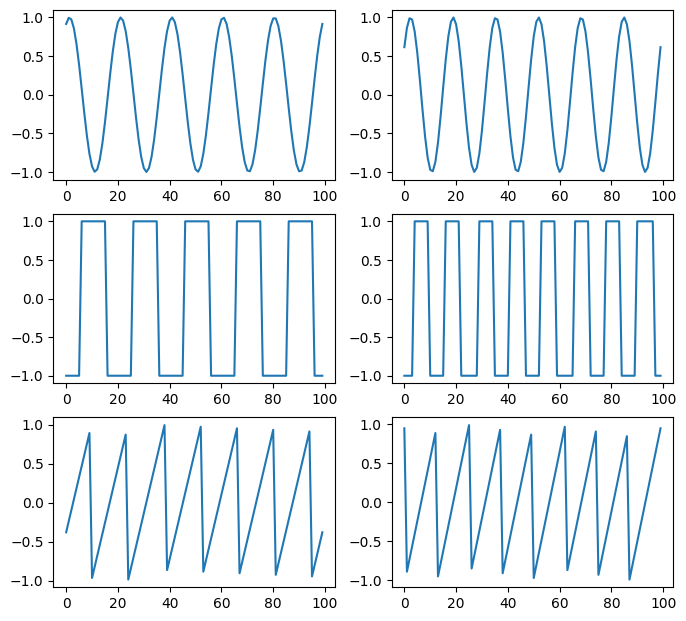

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_waves(X, y, labels=(0,1,2), n_cols = 2):
    n_labels = len(labels)
    fig, axes = plt.subplots(n_labels, n_cols,
                             figsize=(n_cols*4, n_labels*2.5))

    for i, lbl in enumerate(labels):
        idxs = np.where(y == lbl)[0]
        chosen = np.random.choice(idxs, size=n_cols, replace=False)
        for j, idx in enumerate(chosen):
            axes[i, j].plot(X[idx])
    plt.show()

plot_waves(X, y, labels=(0,1,2))

### Generate DataLoader

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

BATCH_SIZE = 64

torch.manual_seed(42)
np.random.seed(42)

X_torch = torch.from_numpy(X).unsqueeze(-1)               # (N, T, 1)
y_torch = torch.from_numpy(y)                             # (N,)

dataset = TensorDataset(X_torch, y_torch)

val_ratio = 0.2
n_val = int(len(dataset) * val_ratio)
n_train = len(dataset) - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

- Demo use of DataLoader

torch.Size([100, 1]) tensor(1) torch.Size([])


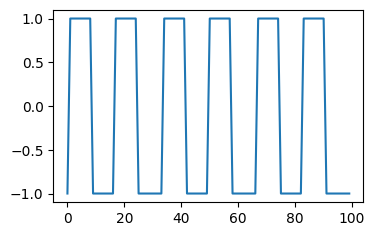

In [4]:
x_batch, y_batch = next(iter(train_loader))
# x_batch: (BATCH_SIZE=64, 100, 1), y_batch: (BATCH_SIZE=64)
x, y = x_batch[0], y_batch[0]
print(x.shape, y, y.shape)
fig, ax = plt.subplots(1, 1, figsize=(1*4, 1*2.5))
ax.plot(x)

## Define RNN Model

In [5]:
import torch
from torch import nn

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)  # output from hidden
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, 
                input_tensor, # (B, input_size)
                hidden_tensor # (B, hidden_size)
               ):
        combined = torch.cat([input_tensor, hidden_tensor], dim=-1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.logsoftmax(self.i2o(hidden))
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

class RNNClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_classes=3):
        super().__init__()
        self.cell = RNNCell(input_size, hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, F)
        B, T, F = x.shape
        h = self.cell.init_hidden(B)
        logprobs = None
        for t in range(T):
            logprobs, h = self.cell(x[:, t, :], h)
        return logprobs 

- Demo use of RNNCell

In [6]:
x_batch, y_batch = next(iter(train_loader))
x = x_batch[36]  # a random sample, x: (100, 1)
print(x.shape)
cell = RNNCell(input_size=1, hidden_size = 8, output_size = 3)
h = torch.zeros(8)
t = 0
o, h_new = cell(x[t], h)
print(h_new)
print(o)

torch.Size([100, 1])
tensor([-0.4350, -0.2697,  0.2645, -0.3281,  0.0096, -0.3387,  0.0877, -0.3541],
       grad_fn=<TanhBackward0>)
tensor([-0.8666, -1.3428, -1.1440], grad_fn=<LogSoftmaxBackward0>)


- Demo use of RNNCell *multiple records*

In [7]:
x_batch, y_batch = next(iter(train_loader))
x = x_batch[36]
cell = RNNCell(input_size=1, hidden_size = 8, output_size = 3)
h = torch.zeros(x_batch.shape[0], 8)
t = 0
print(f"x_batch[:, t, :] is of shape: {x_batch[:, t, :].shape}") # time t value of all waves.
_, h_new = cell(x_batch[:, t, :], h)

x_batch[:, t, :] is of shape: torch.Size([64, 1])


- Demo use of RNNClassifier

In [8]:
x_batch, y_batch = next(iter(train_loader))
input_dim = x_batch.shape[-1] # 1
model = RNNClassifier(input_size=input_dim, hidden_size=8, num_classes=3)
logps = model(x_batch)
print(logps.shape) # each row is a length-3 prob vector.

torch.Size([64, 3])


## Train RNN Model

### Define training step

In [9]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for xb, yb in loader:
        optimizer.zero_grad()
        logps = model(xb)
        loss = criterion(logps, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_correct += (logps.argmax(1) == yb).sum().item()
        total_samples += xb.size(0)
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for xb, yb in loader:
        logps = model(xb)
        loss = criterion(logps, yb)
        total_loss += loss.item() * xb.size(0)
        total_correct += (logps.argmax(1) == yb).sum().item()
        total_samples += xb.size(0)
    return total_loss / total_samples, total_correct / total_samples

### Training Loop

In [10]:
# Hyperparams
HIDDEN = 8
EPOCHS = 10
LR = 2e-3 

model = RNNClassifier(input_size=1, hidden_size=HIDDEN, num_classes=N_CLASSES)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
    va_loss, va_acc = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {ep:02d}: train loss={tr_loss:.4f} acc={tr_acc:.3f} | val loss={va_loss:.4f} acc={va_acc:.3f}")

Epoch 01: train loss=1.1012 acc=0.340 | val loss=1.0982 acc=0.315
Epoch 02: train loss=1.0992 acc=0.329 | val loss=1.0987 acc=0.335
Epoch 03: train loss=1.0990 acc=0.338 | val loss=1.0987 acc=0.315
Epoch 04: train loss=1.0986 acc=0.335 | val loss=1.0986 acc=0.328
Epoch 05: train loss=1.0983 acc=0.324 | val loss=1.0983 acc=0.320
Epoch 06: train loss=1.0962 acc=0.397 | val loss=1.0933 acc=0.327
Epoch 07: train loss=1.0167 acc=0.504 | val loss=1.0258 acc=0.541
Epoch 08: train loss=0.6717 acc=0.680 | val loss=0.5439 acc=0.708
Epoch 09: train loss=0.5184 acc=0.757 | val loss=0.4770 acc=0.774
Epoch 10: train loss=0.5090 acc=0.812 | val loss=0.4469 acc=0.860


In [11]:
@torch.no_grad()
def evaluate_on_full(model, X_all, y_all):
    model.eval()
    logps = model(X_all)
    acc = (logps.argmax(1) == y_all).float().mean().item()
    return acc

full_acc = evaluate_on_full(model, X_torch, y_torch)
print(f"\nAccuracy: {full_acc:.3f}")


Accuracy: 0.859
